<a href="https://colab.research.google.com/github/a22106/ImageClassification/blob/main/ComputerVision/HyperDiff/FastImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 정상, 코로나, 폐렴 분류 딥러닝 모델 구현

# Classification?
## Convolutional Neural Network(CNN)

# Multilayer perceptron(MLP) for CNN
* 입력 값의 가중치 곱셈의 선형 결합과 activation 함수의 비선형 결합으로 연속된 연산을 통해서 입력 값에 대한 연산 수행
* 선형과 비선형성을 활용하여 출력값에 근사하도록 입력값 연산

* 신경망 모델로 어떠한 복잡한 함수도 근사시킬 수 있다 -> **Universal Approximation** Theorem

## 실습 과정
1. 이미지 살펴보기
2. 텐서 연산을 위한 데이터셋 구축하기
3. 분류 모델(VGG19) 아키텍처 불러오기
4. 손실함수(Cross-entropy) 및 최적화 기법(SGDM) 적용하기
5. 모델 학습 및 검증하기
6. 모델 성능 모니터링하기
7. 학습모델 테스트하기

In [16]:
#!unzip "/content/drive/MyDrive/Lecture/컴퓨터비전/Part 3. 컴퓨터비전 응용분야 실습 프로젝트/source/DATASET.zip" -d /content/drive/MyDrive/data/VisionLecture

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/drive/MyDrive/data/VisionLecture/DATASET/Detection/images/de7dd7f10001905b.jpg  
  inflating: /content/drive/MyDrive/data/VisionLecture/DATASET/Detection/images/de7de746a027c655.jpg  
  inflating: /content/drive/MyDrive/data/VisionLecture/DATASET/Detection/images/de83a68b74b02e9e.jpg  
  inflating: /content/drive/MyDrive/data/VisionLecture/DATASET/Detection/images/de896fbf2d4b9b81.jpg  
  inflating: /content/drive/MyDrive/data/VisionLecture/DATASET/Detection/images/de8a45a8c7af2b25.jpg  
  inflating: /content/drive/MyDrive/data/VisionLecture/DATASET/Detection/images/de8e9d04bc07b12f.jpg  
  inflating: /content/drive/MyDrive/data/VisionLecture/DATASET/Detection/images/de8ee94cba09b0b3.jpg  
  inflating: /content/drive/MyDrive/data/VisionLecture/DATASET/Detection/images/de913f2995bdcd6e.jpg  
  inflating: /content/drive/MyDrive/data/VisionLecture/DATASET/Detection/images/de915760f9f459e0.jpg  
  inflating: /content/drive/MyDrive/d

In [37]:
# load image file path
import os

In [38]:
IMAGE_FORMAT = ['jpeg', 'jpg', 'png']

def list_image_files(data_dir, sub_dir):
  image_files = []
  images_dir = os.path.join(data_dir, sub_dir)
  for file_path in os.listdir(images_dir):
    if file_path.split('.')[-1] in IMAGE_FORMAT:
      image_files.append(os.path.join(sub_dir, file_path))
  return image_files

In [39]:
data_dir = "/content/drive/MyDrive/data/VisionLecture/DATASET/Classification/train/"

normals_list = list_image_files(data_dir, "Normal")
covids_list =  list_image_files(data_dir, "Covid")
pneumonias_list = list_image_files(data_dir, "Viral Pneumonia")

print(f"Normal: {len(normals_list)}, Covid:{len(covids_list)}, Pneu:{len(pneumonias_list)}")

Normal: 70, Covid:111, Pneu:70


# 이미지 파일을 RGB 3차원 배열로 불러오기

In [40]:
import cv2

In [41]:
def get_RGB_image(data_dir, file_name):
  image_file = os.path.join(data_dir, file_name)
  image = cv2.imread(image_file)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

# 이미지 데이터 확인하기

In [47]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import torch

In [43]:
# 정상 및 코로나 파일을 하나의 세트로 해서 살펴볼건데 코로나 이미지는 나머지 2개보다 40기 정도가 더 많음 
# 따라서 균일하게 보기 위해서 적은 이미지 기준으로 indexing 하기 위해서 min_num_files를 구성함
min_num_files = min(len(normals_list), len(covids_list), len(pneumonias_list)) 
print(min_num_files)

70


In [44]:
@interact(index = (0, min_num_files -1))
def show_samples(index = 0):
  normal_image = get_RGB_image(data_dir, normals_list[index])
  covid_image = get_RGB_image(data_dir, covids_list[index])
  pneumonias_image = get_RGB_image(data_dir, pneumonias_list[index])

  plt.figure(figsize = (12, 8))
  plt.subplot(131)
  plt.title('Normal')
  plt.imshow(normal_image)
  
  plt.subplot(132)
  plt.title('Covid')
  plt.imshow(covid_image)

  plt.subplot(133)
  plt.title('Pneumonia')
  plt.imshow(pneumonias_image)

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

# 학습데이터셋 클래스 구축

In [45]:
train_data_dir = "/content/drive/MyDrive/data/VisionLecture/DATASET/Classification/train/"
class_list = ['Normal', 'Covid', 'Viral Pneumonia']

In [54]:
class Chest_dataset():
  def __init__(self, data_dir, transformer = None ):
    self.data_dir = data_dir
    normals = list_image_files(data_dir, 'Normal')
    covids = list_image_files(data_dir, 'Covid')
    pneumonias = list_image_files(data_dir, "Viral Pneumonia")

    self.files_path = normals + covids + pneumonias
    self.transformer = transformer


  def __len__(self, ):
    return len(self.files_path)

  def __getitem__(self, index): # 인덱스를 호출하면 그에 따른 image와 label을 반환함
    image_file = os.path.join(self.data_dir, self.files_path[index])
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    print(self.data_dir, self.files_path[index])
    print(self.files_path[index].split(os.sep)[0])
    class_name = self.files_path[index].split(os.sep)[0]
    class_id = class_list.index(class_name)
    if self.transformer:
      image = self.transformer(image)
      class_id = torch.Tensor([target]).long()

    return image, class_id

In [55]:
dset = Chest_dataset(data_dir = train_data_dir)
index = 0
image, target = dset[index]

/content/drive/MyDrive/data/VisionLecture/DATASET/Classification/train/ Normal/01.jpeg
Normal


(1708, 1944, 3)


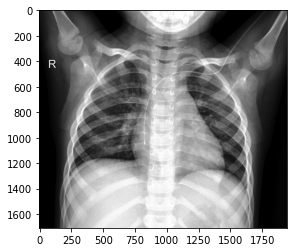

In [57]:
print(image.shape)
plt.imshow(image)